# Word Plot

Helpful reads:

- https://textminingonline.com/dive-into-nltk-part-iv-stemming-and-lemmatization
- https://blog.altoros.com/using-k-means-clustering-in-tensorflow.html
- http://brandonrose.org/clustering
- https://medium.com/@aneesha/using-tsne-to-plot-a-subset-of-similar-words-from-word2vec-bb8eeaea6229
- http://ai.intelligentonlinetools.com/ml/convert-word-to-vector-glove-python/

Links specific to Textblob:

- https://textblob.readthedocs.io/en/dev/quickstart.html#wordnet-integration
- http://www.nltk.org/howto/wordnet.html
- https://stevenloria.com/wordnet-tutorial/

First thing to do is load in the words from the .csv file into an array called `words`.

In [45]:
# Preambe
%matplotlib inline
import sys
import warnings
warnings.filterwarnings('ignore')

In [13]:
import pickle

words = [] # This will contain a list of list which is all the words

def load_words_from_file():
    "Load the words from .csv file"
    with open("data/inference_words.csv", "r") as file:
        content = file.readlines()
    for line in content:
        line_list = line[:-1].split(',')
        global words
        words.append(line_list)
    print('Loaded {} lines from the .csv file.'.format(len(words)))
    # Go ahead and Pickle the words for later use
    with open("output/inference_words.pickle", "wb") as pickle_file:
        pickle.dump(words, pickle_file)
        print("Pickle file created")

def load_words_from_pickle():
    "Load the words from .pickle file"
    with open("output/inference_words.pickle", "rb") as pickle_file:
        global words
        words = pickle.load(pickle_file)
        print('Loaded {} lines from the .pickle file.'.format(len(words)))
        
load_words_from_pickle()

Loaded 823 words from the .pickle file.


### The (naive) model:

This is just the starting point model which gets the ball rolling. Since the words in the top 20 list aren't complete sentences, it can't be expected that this will produce the best result. We will use the list of top 20 words to train a PCA model. This will then be used for the visualization.

In [31]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot

def create_naive_model(min_count = 5):
    "Creates the naive model"
    global model
    model = Word2Vec(words, min_count=5) # Change min_count to 1 to get every occurance
    # Save the model
    model.save("models/simple_model.bin")
    # Print summary about model
    print(model)

def load_model(path = "models/simple_model.bin"):
    "Load a model given a path"
    global model
    model = Word2Vec.load(path)
    print(model)

Word2Vec(vocab=548, size=100, alpha=0.025)


### Visualization for the naive model:
Now that a brief model has been created for the words (via word2vec) and saved as a file called `model.bin` we can focus on trying to get the visualization. 

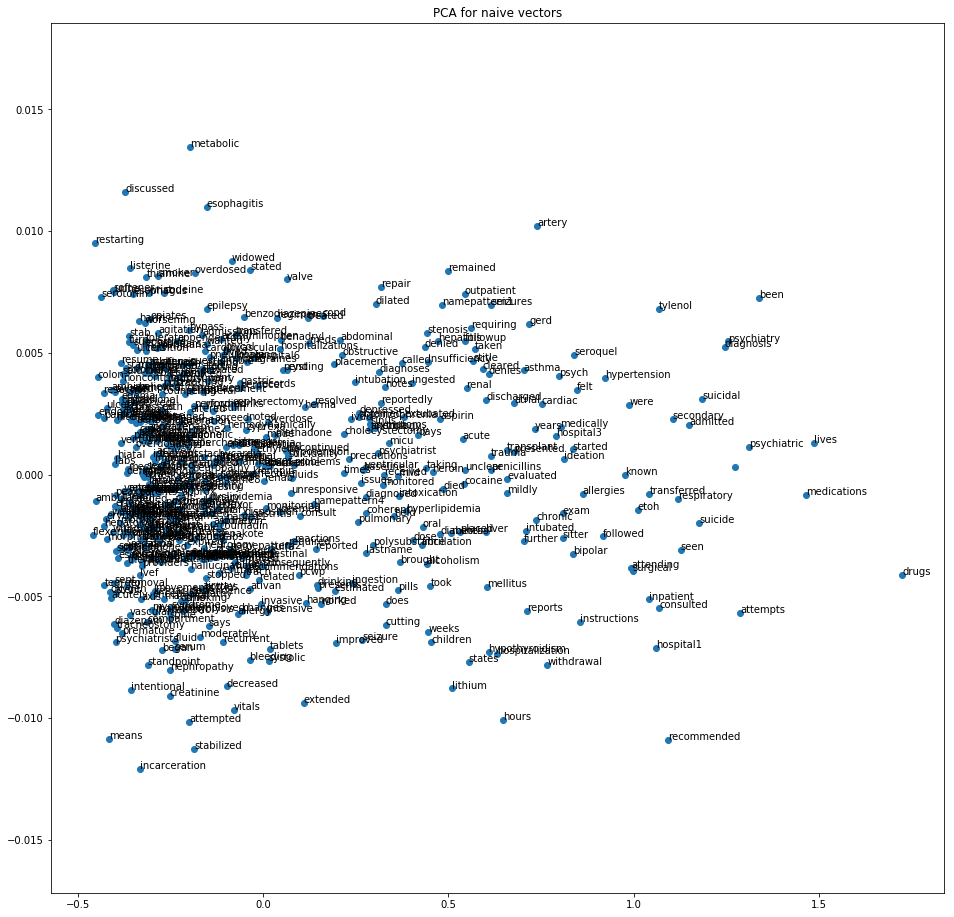

In [53]:
def create_naive_plot():
    "Create plot for the naive model"
    global model
    global model_words # Just a list of our vocab, useful for future models
    vectors = model[model.wv.vocab]
    pca = PCA(n_components=2)
    result = pca.fit_transform(vectors)
    
    # Create the plot
    plot = pyplot.figure(figsize=(16, 16))
    pyplot.title("PCA for naive vectors")
    pyplot.scatter(result[:, 0], result[:, 1])
    model_words = list(model.wv.vocab)
    
    for i, word in enumerate(model_words):
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
        
    pyplot.show()
    
    # Save a .png of the plot
    plot.savefig("output/naive_plot.png")

create_naive_plot()

### Using the embeddings for the PCA:

Instead of just using the 20 words list to get the word vectors, it would be more benficial to use the actual embedder used to train on the data to produce the plots. This is where `data/embedder` comes into play. Here we use the pretrained word2vec embedding to infer specific words from the top 20 list.

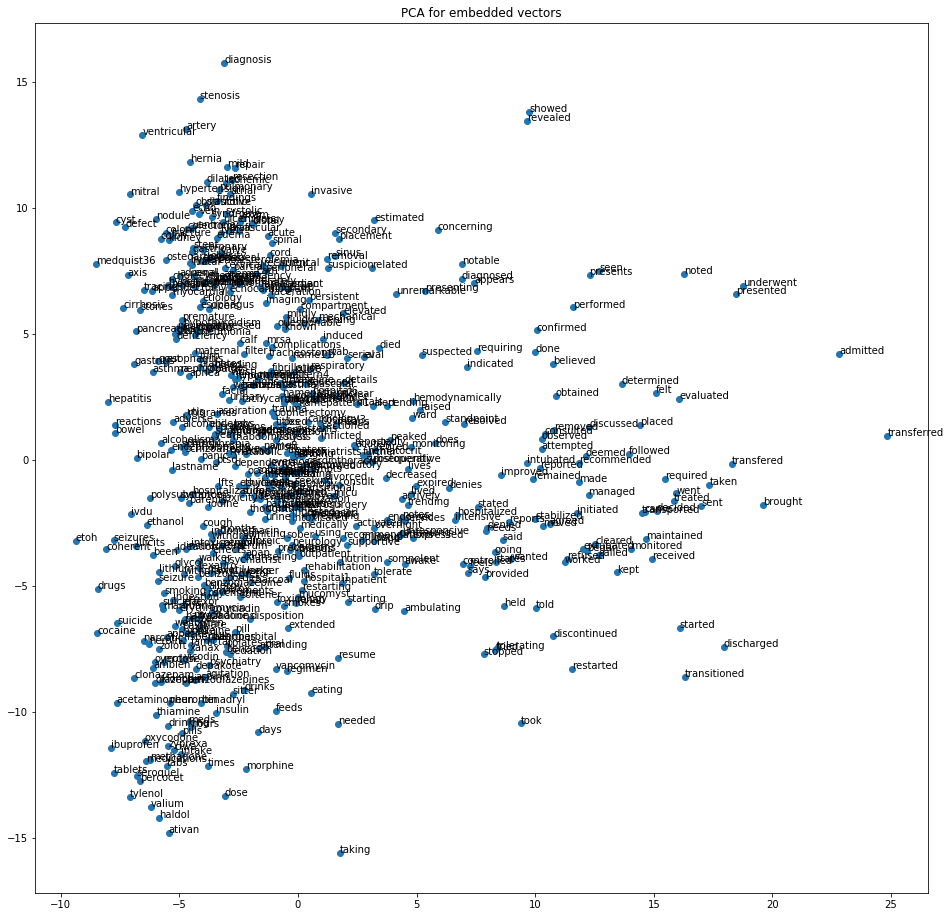

In [59]:
def create_embedded_plot():
    "Import the model from the folder and then create the plot for it"
    global emb_model
    emb_model = Word2Vec.load("data/embedder/processed_full.w2v")
    vectors = emb_model[sorted(model_words)[1:]]
    pca = PCA(n_components=2)
    result = pca.fit_transform(vectors)
    # Make the plot:
    plot = pyplot.figure(figsize=(16, 16)) 
    pyplot.title("PCA for embedded vectors")
    pyplot.scatter(result[:, 0], result[:, 1])

    for i, word in enumerate(sorted(model_words)[1:]):
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))

    pyplot.show()
    
    # Save a .png of the plot
    plot.savefig("output/embedded_plot.png")

create_embedded_plot()

### TSNE approach:

Instead of using PCA we can also use a T-SNE approach to try and reduce the dimensionality of the embedded word vectors.

- https://alexanderfabisch.github.io/t-sne-in-scikit-learn.html
- https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne

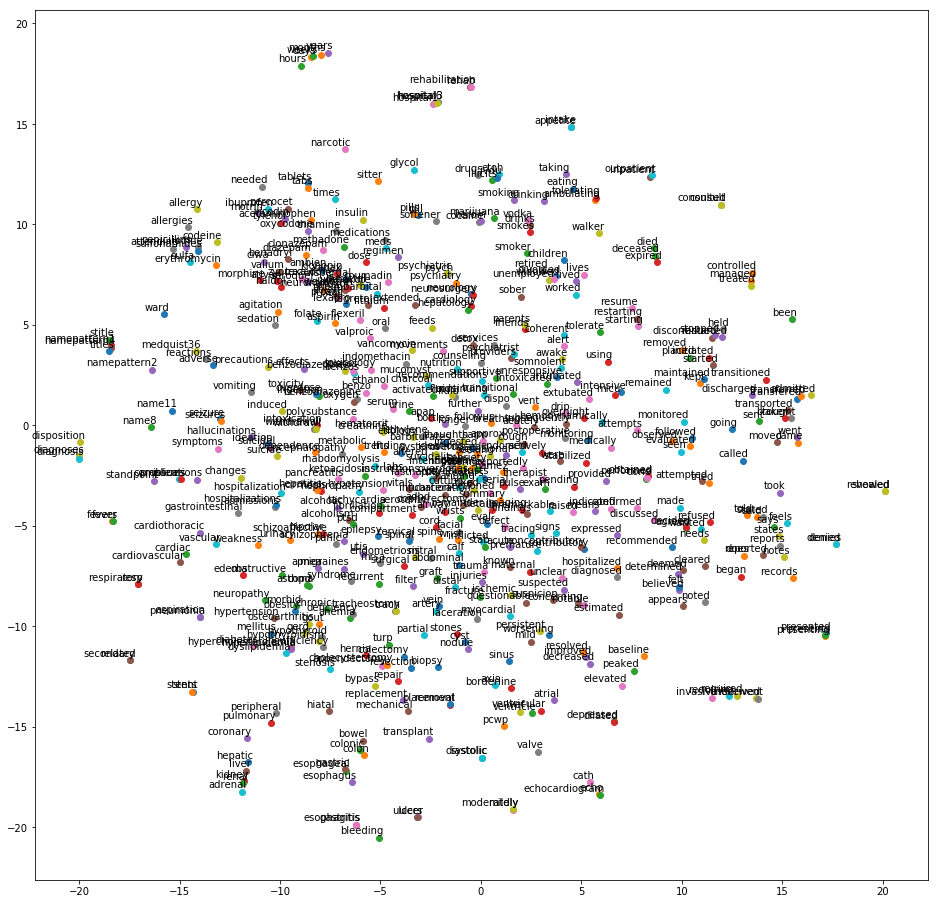

In [58]:
from sklearn.manifold import TSNE
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in sorted(model_words)[1:]:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plot = pyplot.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        pyplot.scatter(x[i],y[i])
        pyplot.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    pyplot.show()
    # Save a .png of the plot
    plot.savefig("output/tsne_embedded_plot.png")
    
tsne_plot(emb_model)

### Interactive Plots

In order to get a much better understanding of the plots, it would be ideal to use an interactive plotting library. That would allow us to use not only ~500 of the most popular words on the top 20 list, but also use all ~3400 or so words from the top 20 list. I also believe the groupings will be made more clear

In [26]:
# Use Plotly for the interactive visuals:
from plotly.offline import init_notebook_mode
import plotly.plotly as py
import plotly.graph_objs as go


import plotly
plotly.tools.set_credentials_file(username='DemoAccount', api_key='lr1c37zw81')


init_notebook_mode(connected=True)

import numpy as np

N = 1000
random_x = np.random.randn(N)
random_y = np.random.randn(N)

# Create a trace
trace = go.Scatter(
    x = random_x,
    y = random_y,
    mode = 'markers'
)

data = [trace]

In [27]:
py.iplot(data, filename='basic-scatter')

PlotlyRequestError: Aw, snap! You tried to use our API as the user 'DemoAccount', but the supplied API key doesn't match our records. You can view your API key at https://plot.ly/settings/api

You're most likely getting this message because your local credentials file isn't synced with the Plotly server you're communicating with.

Go to https://plot.ly/<language>/getting-started (e.g., https://plot.ly/python/getting-started) for more information.

Make sure that you're logged in as DemoAccount.

Need help? Please try searching Plotly's <a href='http://stackoverflow.com/questions/tagged/plotly'>Stack Overflow channel</a>.